<a href="https://colab.research.google.com/github/MoritzTaylor/UCL_Advanced_Deep_Learning_and_Reinforcement_Learning/blob/master/lecture%20assignments/Solved/Deep%20Learning/DL_cw3_questions%20-%20solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Homework 3

-------------------------------


**Name:** Your Name

**SN:** Your Student Number

-----------------------------------


**Start date:** *12th Feb 2018*

**Due date:** *5th March 2018, 11:55 pm*

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_DL_hw3.ipynb** before the deadline above.

Also send a **sharable link** to the notebook at the following email: ucl.coursework.submit@gmail.com. You can also make it sharable via link to everyone, up to you.

Please compile all results ( table in Q2) and all answers to the understanding/analysis results questions (Q1 and Q3), into a PDF. Name convention: **studentnumber_DL_hw3.pdf**. Do not include any of the code (we will use the notebook for that). 

**Page limit: 7 pg ** (w/o the bonus question).

------------------------------------------------

## MNIST as a sequence
In this assignment we will be using the [MNIST digit dataset](https://yann.lecun.com/exdb/mnist/). The dataset contains images of hand-written digits ($0-9$), and the corresponding labels. The images have a resolution of $28\times 28$ pixels. This is the same dataset as in Assignment 1, but we will be using this data a bit differently this time around. Since this assignment will be focusing on recurrent networks that model sequential data, we will be looking at each image as a sequence: the networks you train will be "reading" the image one row at a time, from top to bottom (we could even do pixel-by-pixel, but in the interest of time we'll do row-by-row which is faster).  Also, we will work with a binarized version of MNIST -- we constrain the values of the pixels to be either $0$ or $1$. You can do this by applying the method `binarize`, defined below, to the raw images.

<img src="https://github.com/bodono/files/blob/master/mnist_as_sequence.png?raw=true">

* We take the MNIST images, binarise them, and interpret them as a sequence of pixels from top-left to bottom-right. ("Task 2" refers to the next homework, wherein you will be using the sequence for pixel prediction).

## Recurrent Models for MNIST

As discussed in the lectures, there are various ways and tasks for which we can use recurrent models. A depiction of the most common scenarios is available in the Figure below. In this assignment and the following one we will look at two of these forms: **many-to-one** (sequence to label/decision) and the **many-to-many** scenario where the model receives an input and produces an output at every time step. You will use these to solve the following tasks: i) classification (*this homework*), ii) pixel prediction (*next homework*) and iii) in-painting (*next homework*).

<img src="https://github.com/bodono/files/blob/master/rnn_models.png?raw=true">
* ([Figure adapted from Karpathy's The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness)). You will be implementing variants of *many-to-one* for classification (in this homework), and *many-to-many* for prediction (in the next homework).


## Q1: Understanding LSTM vs GRU (30 pts)
Before going deeper into your practical tasks, take some time to revise and make sure you understand the two major types of recurrent cells you will be using in this assignment: Long-Short Term Memory Units (LSTM) first introduced by Hochreiter and Schmidhuber [1997] and the more recent Gated Recurrent Units (GRU) by Cho et al. [2014]. Once you have done this, answer the following questions:

1. Can LSTMs (and respectively GRUs) just store the current input in the state ($c_t$ for LSTM and $h_t$ for GRU, in the class notation) for the next step? If so, give the gates activation that would enable this behaviour. If not, explain why not. [10 pts]
2. Can LSTMs (and respectively GRUs) just store a previous state into the current state and ignore the current input? If so, give the gates' activation that would enable this. If not, explain why not. [10 pts]
3. Are GRUs a special case of LSTMs? If so, give the expression of the GRU gates in term of LSTM's gates ($o_t, i_t, f_t$). If not, give a counter-example. Assume here the same input. [10 pts]

**Word limit: ** 1000 words or less

**Answers:**
1. No, it would not be possible. To realise this, the forget gate $f_t$ should output 0 for every number in the cell state $c_{t-1}$, while the input gate $i_t$ should output 1 for every number in the cell state $c_{t-1}$. Since the sigmoid function of the gates, can only be 0 or 1 in infinity, it is practically impossible. Furthermore to use only the current input, we have to zero-out $h_{t-1}$, so that it does not get incorporated into the input gate. This means that the weight matrix $W_{ih}$ of $h_{t-1}$ has to be zero for every value of $h_{t-1}$. In a GRU, we have a similar situation.

2. To realise this behaviour in a LSTM, the input gate $i_t$ should ouput 0 for every number in the cell state $c_{t-1}$, while the forget gate $f_t$ should output 1 for every number in the cell state $c_{t-1}$. But again, the sigmoid function will never be 0 or 1. Nevertheless this scenario would be possible, if $j_t$ would be 0. Then only the last cell state $c_{t-1}$ will be incorporated into $c_t$. In a GRU, the output $z_t$ should be 1 for every number in the cell state $h_{t-1}$. Then $\tilde{h}$ will be ingnored completly. Since $z_t$ is calculated with a sigmoid function again, this scenario will not be possible practically.

3. GRU combines the forget and input gates into a single “update gate.” It also merges the cell state $c_t$ and hidden state $h_t$, and makes some other changes. The resulting model is simpler than a standard LSTM model. ...




## Q2: Implementation. Line-by-Line MNIST Classification (50 pts)
In this part you will train a number of many-to-one recurrent models that takes as input: an image (or part of an image) as a sequence (row by row) and after the last input row produces, as output, a probability distribution over the $10$ possible labels ($0-9$). The models will be trained using a cross-entropy loss function over these output probabilities.

### Optimization
Use the Adam optimizer (with default settings other than the learning rate) for training.

**[Optional]** Sometimes dropout has been shown to be beneficial in training recurrent models, so feel free to use it or any other form of regularization that seems to improve performance. It might be also worth trying out batch-normalization. [Reference](https://arxiv.org/pdf/1603.09025.pdf).

### Models: Your models will have the following structure:
1. [(Red Block)] The *input* (current binarised row of pixels) can be fed directly into the recurrent connection without  much further pre-processing. The only thing you need to do is have an affine transformation to match the dimensionality of the recurrent unit, i.e. one of $(32, 64, 128)$.
2. [(Blue Block)] The *output* (probabilities over the 10 classes) is produced by looking at the last output of the recurrent units, transforming them via an affine transformation.
3. [(Green Block)] For the *recurrent* part of the network, please implement and compare the following architectures:
    * LSTM with 32, 64, 128 units. [15 pts]
    * GRU with 32, 64, 128 units. [15 pts]
    * stacked LSTM: 3 recurrent layers with 32 units each. [10 pts]
    * stacked GRU: 3 recurrent layers with 32 units each. [10 pts]

Your network should look like:
\begin{equation}
\textrm{Input} \Rightarrow \textrm{RNN cell} \Rightarrow \textrm{Relu} \Rightarrow \textrm{Fully connected} \Rightarrow \textrm{Relu} \Rightarrow \textrm{Fully connected} \Rightarrow \textrm{Output}
\end{equation}
You might find the function `tf.nn.dynamic_rnn` useful.

### Hyper-parameters 
For all cases train the model with these hyper-parameter settings:

- *num_epochs*=10, *learning_rate*=0.001, *batch_size*=256, *fully_connected_hidden_units=64*

With these hyper-parameters you should be comfortably above $95\%$ test set accuracy on all tasks. (Feel free to try other settings, there are certainly better choices, but please report the results with these exact hyper-parameters). Please report the *cross-entropy* and the *classification accuracy* for the *test set* of the models trained. Use the `plot_summary_table` method below to format the table.


##Q3: Analyse the results (20 pts + 10 pts)

1. How does this compare with the results you obtained in the first assignment(DL1), when training a model that "sees" the entire image at once? Explain differences. [5 pts]
2. Let us take a look closer look at one of the trained models: say GRU (32). Plot the outputs of the RNN layer and hidden state over time. In particular, look at the first 3-5 time steps. Plot the input image along side. 
You can use ```python
plt.imshow(output_GRU_over_time)
```
for these, where ```output_GRU_over_time.shape``` is (T=28,hidden_units) dimensional. What do you observe? Show at least one pair of these plots to support your observation(s). [5 pts]
3. Now, look at the last 3-5 time steps. What do you observe? When is the classification decision made? To validate your answer to the second part of the question, provide the classification predictions for the last 5 time steps -- that is, pretend whatever the output of the GRU is at that time step is in fact the last output in the computation, and feed that into the classification mapping. [10 pts] 

**Word limit:** 500 words or less 


**[Bonus]** Let's looking inside the computation. Take one of the previous LSTM models (for simplicity pick one of the one-layer recurrence models) and track the status of the gates ($o_t, i_t, f_t$) over time. Note that if you used the provided RNNCell wrappers (BasicLSTMCell and co) in tensorflow, these will keep this information hidden, so you will need to implement your own version of this recurrence layer, or mirror the one in tensorflow, but now exposing these hidden variables. A bit of warning: this is not trivial and will require some thinking on the coding side, but it will also provide you with a more informative way of visulazing the inner computation.  [10 pts]

**Word limit:** 300 words or less 

# Imports and utility functions (do not modify!)

In [0]:
# Import useful libraries.
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

# Binarize the images
def binarize(images, threshold=0.1):
  return (threshold < images).astype('float32')

# Import dataset with one-hot encoding of the class labels.
def get_data():
  return input_data.read_data_sets("MNIST_data/", one_hot=True)

# Placeholders to feed train and test data into the graph.
# Since batch dimension is 'None', we can reuse them both for train and eval.
def get_placeholders():
  x = tf.placeholder(tf.float32, [None, 784])
  y = tf.placeholder(tf.float32, [None, 10])
  return x, y

# Generate summary table of results. This function expects a dict with the
# following structure: keys of 'LSTM' or 'GRU' and the values for each key are a
# list of tuples consisting of (test_loss, test_accuracy), and the list is
# ordered as the results from 32 units, 64 units, 128 units, 3 x 32 units, i.e.:
# {
#  'LSTM': [(loss,acc), (loss, acc), (loss, acc), (loss, acc)]
#  'GRU': [(loss,acc), (loss, acc), (loss, acc), (loss, acc)]
# }
def plot_summary_table(experiment_results):
  # Fill Data.
  cell_text = []
  columns = ['(1 layer, 32 units)', '(1 layer, 64 units)', '(1 layer, 128 units)', '(3 layers, 32 units)']
  for k, v in experiment_results.iteritems():
    rows = ['Test loss', 'Test accuracy']
    cell_text=[[],[]]
    for (l, _) in v:
      cell_text[0].append(str(l))
    for (_, a) in v:
      cell_text[1].append(str(a))

    fig=plt.figure(frameon=False)
    ax = plt.gca()
    the_table = ax.table(
      cellText=cell_text,
      rowLabels=rows,
      colLabels=columns,
      loc='center')
    the_table.scale(2, 8)
    # Prettify.
    ax.patch.set_facecolor('None')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(-0.73, 0.9, k, fontsize=18)

# Train Models

Generate summary table of results. This function expects a dict with the
following structure: keys of 'LSTM' or 'GRU' and the values for each key are a
list of tuples consisting of (test_loss, test_accuracy), and the list is
ordered as the results from 32 units, 64 units, 128 units, 3 x 32 units, i.e. expected dictionary (final performace only):

```python
{
  'LSTM': [(loss,acc), (loss, acc), (loss, acc), (loss, acc)]
  'GRU': [(loss,acc), (loss, acc), (loss, acc), (loss, acc)]
}
```

In [2]:
mnist = input_data.read_data_sets('./mnist', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
def FullyConnectedPart(x):
  # ReLU with the output of the RNN-Cell given as x
  y_1 = tf.nn.relu(x)
  
  # Linear activation + ReLU
  y_2 = tf.nn.relu( tf.matmul(y_1, W_1) + b_1 )
  
  y_logits = tf.matmul(y_2, W_2) + b_2
  return tf.nn.softmax( y_logits ), y_logits


def LSTM(x):
  # Prepare data shape to match `lstm` function requirements
  # Current data input shape: (batch_size, timesteps*n_input)
  # Required shape: 'timesteps' tensors list of shape (batch_size, timesteps, num_input)
  
  # Reshape to get a tensor with shape: (batch_size, timesteps, num_input)
  image = tf.reshape(x, [-1, timesteps, num_input])
  
  # Define a lstm cell with tensorflow
  lstm_cell = tf.nn.rnn_cell.LSTMCell(num_hidden_RNN)
  
  # Get lstm cell output
  outputs, states = tf.nn.dynamic_rnn(
      lstm_cell, 
      image,                      # image
      initial_state=None,         # the initial hidden state
      dtype=tf.float32,           # must given if set initial_state = None
      time_major=False,           # False: (batch, time step, input); True: (time step, batch, input)
  )
  
  # Returning rnn inner loop last output
  return outputs[:, -1, :]

  
def GRU(x):
  
  # Prepare data shape to match `rnn` function requirements
  # Current data input shape: (batch_size, timesteps*n_input)
  # Required shape: 'timesteps' tensors list of shape (batch_size, timesteps, num_input)
  
  # Reshape to get a tensor with shape: (batch_size, timesteps, n_input)
  image = tf.reshape(x, [-1, timesteps, num_input])
  
  # Define a lstm cell with tensorflow
  gru_cell = tf.nn.rnn_cell.GRUCell(num_hidden_RNN)
  
  # Get lstm cell output
  outputs, states = tf.nn.dynamic_rnn(
      gru_cell, 
      image, 
      dtype=tf.float32
  )
  
  # Returning rnn inner loop last output
  return outputs[:, -1, :]

In [0]:
# Your training session here

In [0]:
# Training Parameters
learning_rate = 0.001
batch_size = 256
num_epochs = 10

# Using Xavier Init
initializer = tf.contrib.layers.xavier_initializer() 

# Network Parameters
num_input = 28 # MNIST data input (img shape: 28*28)
timesteps = 28 # timesteps
num_classes = 10 # MNIST total classes (0-9 digits)
fully_connected_hidden_units = 64 # Num of hidden units in the fc layers

experiment_results = {
    "LSTM": [],
    "GRU": []   
}

In [6]:
# LSTM with 32, 64 and 128 units
num_hidden_RNN_list = [32, 64, 128] # rnn hidden layer num of features

for num_hidden_RNN in num_hidden_RNN_list:
  print "Iteration with hidden size " + str(num_hidden_RNN)
  
  # Reset graph in every iteration
  tf.reset_default_graph()
  
  # tf Graph input
  X, Y = get_placeholders()

  # Init weight and bias for the fc layers
  W_1 = tf.Variable(initializer( [num_hidden_RNN, fully_connected_hidden_units]  ))
  b_1 = tf.Variable(initializer( [fully_connected_hidden_units] ) )

  W_2 = tf.Variable(initializer( [fully_connected_hidden_units, num_classes]  ))
  b_2 = tf.Variable(initializer( [num_classes] ) )

  lstm_output = LSTM(X)
  prediction, logits = FullyConnectedPart(lstm_output)

  # Define loss and optimizer
  loss_op = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          logits=logits, 
          labels=Y
      )
  )
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(loss_op)
  
  # Evaluate model (with test logits, for dropout to be disabled)
  correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

  # Initialize the variables (i.e. assign their default value)
  init = tf.global_variables_initializer()

  # Start training
  with tf.train.MonitoredSession() as sess:
    while mnist.train.epochs_completed < num_epochs:
    
      # Get batch from training data
      batch_x, batch_y = mnist.train.next_batch(batch_size)

      # Binarize the batch data
      batch_x = binarize(batch_x)
    
      # Run optimization op (backprop)
      sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
    
    # Calc loss and accuracy
    test_data = mnist.test.images
    test_data = binarize(test_data)
    test_label = mnist.test.labels
    loss, acc = sess.run([loss_op, accuracy], feed_dict={X: test_data, Y: test_label})
    experiment_results["LSTM"].append( (loss, acc) )

Iteration with hidden size 32
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteration with hidden size 64
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteration with hidden size 128
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [7]:
# GRU with 32, 64 and 128 units
num_hidden_RNN_list = [32, 64, 128] # rnn hidden layer num of features

for num_hidden_RNN in num_hidden_RNN_list:
  print "Iteration with hidden size " + str(num_hidden_RNN)
  # Reset graph in every iteration
  tf.reset_default_graph()
  
  # tf Graph input
  X, Y = get_placeholders()

  # Init weight and bias for the fc layers
  W_1 = tf.Variable(initializer( [num_hidden_RNN, fully_connected_hidden_units]  ))
  b_1 = tf.Variable(initializer( [fully_connected_hidden_units] ) )

  W_2 = tf.Variable(initializer( [fully_connected_hidden_units, num_classes]  ))
  b_2 = tf.Variable(initializer( [num_classes] ) )

  gru_output = GRU(X)
  prediction, logits = FullyConnectedPart(gru_output)

  # Define loss and optimizer
  loss_op = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          logits=logits, 
          labels=Y
      )
  )
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(loss_op)
  
  # Evaluate model (with test logits, for dropout to be disabled)
  correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

  # Initialize the variables (i.e. assign their default value)
  init = tf.global_variables_initializer()

  # Start training
  with tf.train.MonitoredSession() as sess:
    while mnist.train.epochs_completed < num_epochs:
    
      # Get batch from training data
      batch_x, batch_y = mnist.train.next_batch(batch_size)

      # Binarize the batch data
      batch_x = binarize(batch_x)
    
      # Run optimization op (backprop)
      sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
    
    # Calc loss and accuracy
    test_data = mnist.test.images
    test_data = binarize(test_data)
    test_label = mnist.test.labels
    loss, acc = sess.run([loss_op, accuracy], feed_dict={X: test_data, Y: test_label})
    experiment_results["GRU"].append( (loss, acc) )

Iteration with hidden size 32
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteration with hidden size 64
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Iteration with hidden size 128
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


#Results

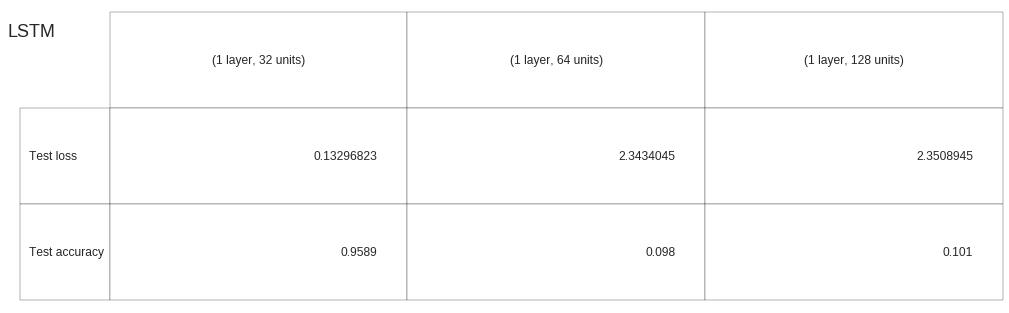

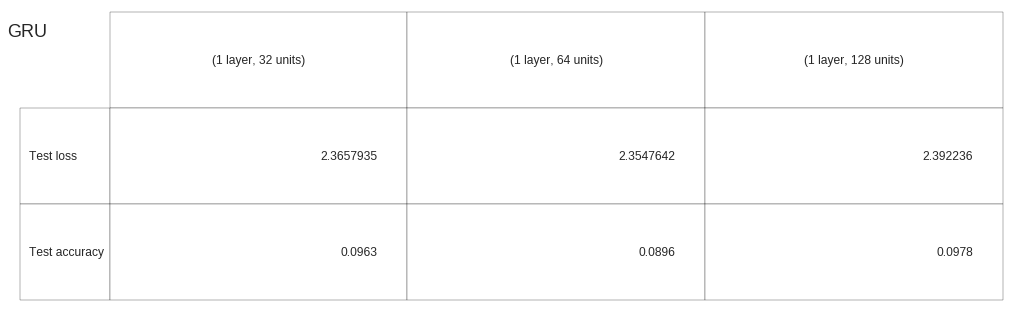

In [8]:
plot_summary_table(experiment_results)

# Analysis of results

In [9]:
# Look into the GRU computation over time

# plot one sample over time
plt.imshow(output_GRU_over_time)
plt.imshow(binarized_input_image)

# Feel free to pick a sample from the dataset that more closely supports your 
# answers in Q3.

# first 5 steps in the computation
plt.imshow(output_GRU_over_time[:5,:])

# last 5 steps in the computation
plt.imshow(output_GRU_over_time[:5,:])

NameError: ignored